# Asset Pre-Assessment: GLD as a Case Study in Prescious Metals

GLD is the ticker symbol for the SPDR Gold Shares ETF, which is one of the most popular exchange-traded funds (ETFs) that tracks the price of gold. The fund aims to provide investment results that closely correspond to the performance of the price of gold bullion. It does this by holding physical gold in vaults, and investors in GLD essentially own a share of that gold.

This workflow uses historical data to assess simple trend fitting, 
autocorrelation and robust statistics for estimating risk and return metrics.
For robust statistics, we use the median to estimate a parameters expected value
and the Median Absolute Deviation (MAD) with normal corrrection 
as a measure of dispersion of the data around the expected value.
Original choices in methodology were made in Project 202410.

The goal here is to identify:
* sample frequency/interval;
* sample period;
* abnormal price deviation event lengths; and
* expected returns as a function of hold time.

### *Notice*
*We stress that none of our Jupyter Notebook projects are to be considered final and of publication quality unless otherwise stated. We also provide no warranty or guarantee of any kind. These projects are meant for testing code and learning concepts in a transparent, and often evolving manner. If new methodologies, stratagies or fundamental understandings are applied in the future, they will most likely be explored in future projects. For transparency and documentation, old projects will not be removed but instead will be deprecated (and clearly marked as such). Look for updates on GitHub https://github.com/Rtasseff/condor_test/tree/main/project*

## Setup

In [1]:
# data set
datasetName = 'GLD_MAX.tab'

# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'
import sys
# adding analytics to the system path
sys.path.insert(0, '/Users/rtasseff/projects/condor_test/analytics')

from data_mining import load
from functions import genStats
from functions import genFin
from functions import assetPreassess as apa
from functions import utils


import numpy as np
import matplotlib.pyplot as plt


## I. Data 
We are using the full 20 year history of the SPDR GLD ETF (2004-2024), 
obtained from Yahoo Finance under the symbol GLD.

### i. Load Price

Show pricing data by date and plot.
Here we are using the adjusted closing price as our main daily indicator.

<class 'pandas.core.frame.DataFrame'>
Index: 5036 entries, 5035 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5036 non-null   datetime64[ns]
 1   Open         5036 non-null   float64       
 2   High         5036 non-null   float64       
 3   Low          5036 non-null   float64       
 4   Close*       5036 non-null   float64       
 5   Adj Close**  5036 non-null   float64       
 6   Volume       5036 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


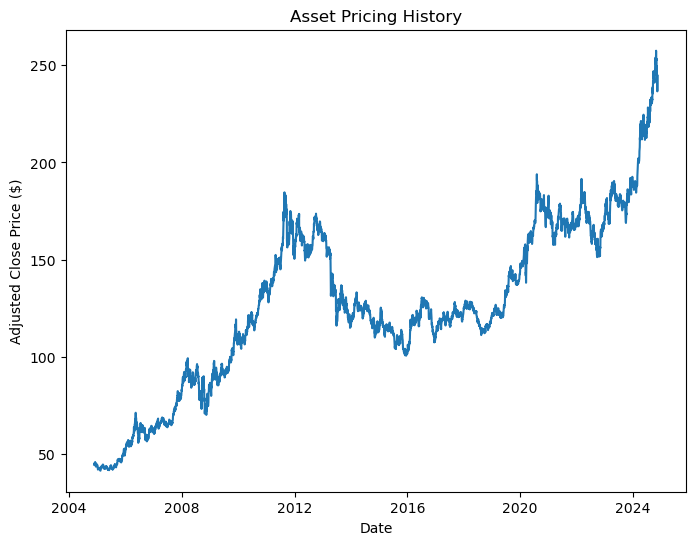


----------
Time Span: 240 months
Number of points sampled: 5036


In [2]:


# get data


dates,prices = load.assetHist_CSV(dataDir+'/'+datasetName, sep='\t')

#dates = dates[2500:]
#prices = prices[2500:]

print('')
print('----------')
print('Time Span: '+str(np.datetime64(dates[-1], 'M')-np.datetime64(dates[0], 'M')))
print('Number of points sampled: '+str(len(dates)))



### ii. Caculate Returns
In the future, we will be considering many estimates over monthly relative returns.
We feel this may actually be a more important feature, vs price, 
to look at for exploring certain detials.  For example, 
in Projects 202407 and 20409, we found long term memory and high noise 
(as determined from the autocorrelation function) in the price. 
Therefore we chose to consider the returns for determining the samplining frequence.

Here we defined a month to be 21 consecutive adjusted closing day prices. 
We are considering set 30 day period for a month. 
Stock is traded and recorded only when the market is open, 
so our time series only contains weekdays.
We are removing 2 weekends days per week. 
A 30 day month, given 4.25 weeks each month, yields 8.5 weekend days.
We removed 9 days to account for a handful of holidays.
Importantly, this is consistant with the number of data points over a
spepcific range of time as confirmed in past studies.

As a matter of practice, we are considering relative returns.
 


[-0.00090131 -0.01250558 -0.02068966 ... -0.04051419 -0.03172518
 -0.03666365]
['2004-12-20T00:00:00.000000000' '2004-12-21T00:00:00.000000000'
 '2004-12-22T00:00:00.000000000' ... '2024-11-18T00:00:00.000000000'
 '2024-11-19T00:00:00.000000000' '2024-11-20T00:00:00.000000000']


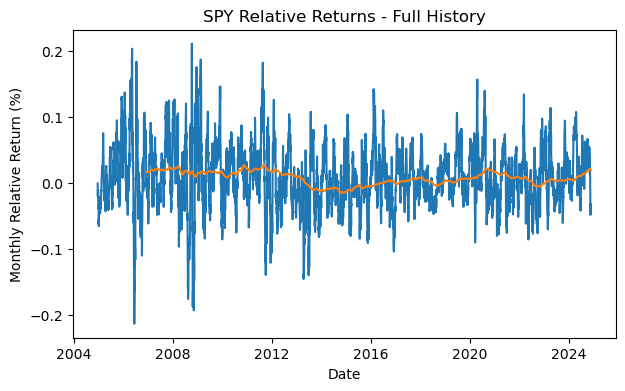

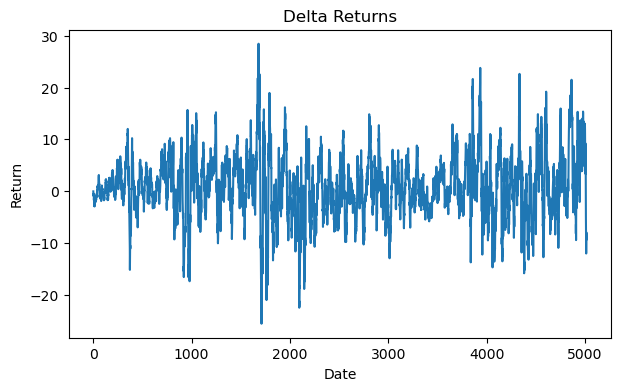

In [3]:
# conversion factor for months to consecutive points *USER SET*
month2days = 21

returns = genFin.returns(prices,period=month2days)
inds = np.arange(0,len(returns))+month2days
dates_returns = dates[inds]

# Show for sanity check
print(returns)
print(dates_returns)

# moving averages for fun
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

returnsMA = moving_average(returns, 500)

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_returns, returns)
plt.plot(dates_returns[499:], returnsMA)

plt.xlabel('Date')
plt.ylabel('Monthly Relative Return (%)')
plt.title('SPY Relative Returns - Full History')
plt.show()

#Plot the non relative data for fun
plt.figure(figsize=(7, 4))
plt.plot(np.arange(0,len(returns)), genFin.returns(prices,period=month2days,metric='Delta'))
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Delta Returns')
plt.show()


General we found the relative returns to show no clearly visible trend.
There are a few major spikes (up and down) around the 2008 houseing market crash.
During this time the spot price for gold did drastically decrease with the market;
however, it recovered rapidly and went on to provide comparitavly strong returns 
through the great recession.

There is not enough data here to consider possible pre-2000 diffences as 
we did in projects 202411_apa_SP500 and Russ2000.
While the ETF GLD did not yet exist, we could use historical, 
daily gold spot prices in this same analysis workflow.
More investigation is planned.

## II. Sampling Frequency/Interval 

For any statistical analysis, we have to determine how much time will pass 
between t<sub>i</sub> and <sub>i+1</sub> in our data set. 
In our experience, this is often arbitrarily determined, 
but here we considered a more formal statistical approach. 
We want to maximize the number of sampling points while minimizing their dependence since a proper statistical analysis would require statistically independent samples.
We would like to select a sampling rate that minimizes the statistical dependance between data points that is driven simply by proximity in time, 
but keep as many data points as possible to boost statistical power. 
In a perfect senario this would be done by considering the elapsed time for the Auto-Correlation Function (ACF) to drop and then remain at zero. 
Of course, in any real-world data there is noise that keeps this from happening. 
In complex non-linear systems like the stock market 
there is also the high possibility of long-term memory effects as observed 
when the ACF does not approach zero or deviates from it after a period of time. 
We arbitrary chose a cutoff of +/-0.05 around the zero to be considered 'reasonably' near zero.

Previously (Project 202409), we formulated a set of rules 
to systematically select a sampling frequency from the ACF. 
First, we chose to require that the zero was within the 95% CI of the ACF value. 
This is a necessary but not a sufficient condition for being near zero. 
We also chose to require the ACF value to be within the cutoff range 
defined above as +/- 0.05. 
We went further to require the above to be true for one month, 
defined above as 21 days (i.e. 21 consecutive data points in the time course). 
Since the returns are 21 days, it stands to reason we would like our samples to be spaced such that they are nearly uncorrelated over 21 days.

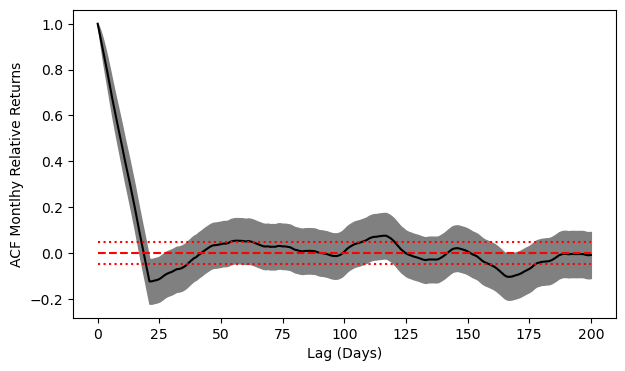

Return ACF
[ 1.00000000e+00  9.46516119e-01  8.92257441e-01  8.39033502e-01
  7.84237679e-01  7.26821020e-01  6.69073217e-01  6.15218494e-01
  5.62830798e-01  5.11725768e-01  4.60084813e-01  4.05837786e-01
  3.56318001e-01  3.06331909e-01  2.54019926e-01  2.01084530e-01
  1.44109433e-01  8.85614319e-02  3.46882022e-02 -1.75705114e-02
 -7.14402345e-02 -1.23780445e-01 -1.23380167e-01 -1.20235248e-01
 -1.17782202e-01 -1.13720824e-01 -1.06263742e-01 -9.77804120e-02
 -9.09256427e-02 -8.61816781e-02 -8.24842446e-02 -7.66324691e-02
 -7.06680942e-02 -6.95412529e-02 -6.64166112e-02 -6.04472880e-02
 -5.27008530e-02 -4.19709349e-02 -3.21102590e-02 -2.30340612e-02
 -1.73527110e-02 -7.88451824e-03 -7.96864686e-04  8.44170846e-03
  1.59018959e-02  2.33004441e-02  2.99619960e-02  3.38321137e-02
  3.46001065e-02  3.65528421e-02  3.84262906e-02  4.12226587e-02
  4.10448516e-02  4.37062239e-02  5.00470352e-02  5.24758028e-02
  5.38629561e-02  5.35839439e-02  5.32471576e-02  5.24244235e-02]
Return ACF 95

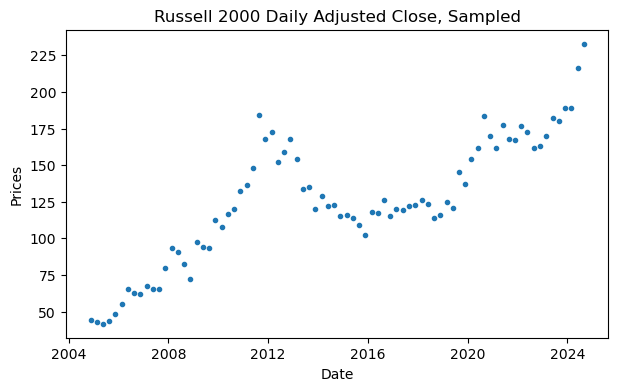

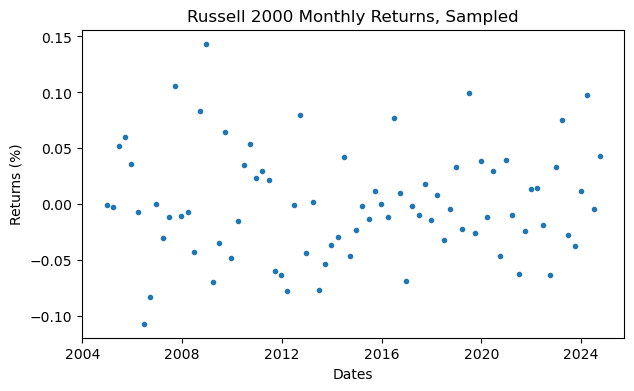

In [16]:
# +/- cutoff for 'near zero' ACF values *USER SET*
acfCutoff = 0.05

# Calc autocorr
acf_return, lag_return, acfConf_return = genStats.acf(returns,fracLag=0.04)


# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(lag_return, acf_return,color='black',label='full')

plt.plot(lag_return, lag_return*0 ,'r--') 
plt.plot(lag_return, lag_return*0 + acfCutoff,'r:') 
plt.plot(lag_return, lag_return*0 - acfCutoff,'r:') 
plt.fill_between(lag_return,acfConf_return[:,0],acfConf_return[:,1],color='gray')
plt.xlabel('Lag (Days)')
plt.ylabel('ACF Montlhy Relative Returns')
#plt.title('')
plt.show()


print('Return ACF')
print(acf_return[:60])
print('Return ACF 95% Conf')
print(acfConf_return[:60].T)


sampFreq = apa.find_samp_freq(returns, cutoff=acfCutoff, period=month2days, fracLag=0.04)


print('Samp Freq')
print('- Full Data Set '+str(sampFreq))

# Parse out the proper sample data
n = len(prices)
inds = np.arange(0,n,sampFreq)
prices_samp = prices[inds]
dates_samp = dates[inds]


n = len(returns)
inds = np.arange(0,n,sampFreq)
returns_samp = returns[inds]
dates_returns_samp = dates_returns[inds]

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_samp,prices_samp,'.')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Russell 2000 Daily Adjusted Close, Sampled')
plt.show()

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_returns_samp,returns_samp,'.')
plt.xlabel('Dates')
plt.ylabel('Returns (%)')
plt.title('Russell 2000 Monthly Returns, Sampled')
plt.show()



We found a sampling interval of 63 days to be sufficent to 
meet the pre-determined selection criterion.
The Auto Correlation Function for this precious metal asset was smoother 
than that of the small and large cap stock indices.
GLD demonstrated features common to dynamic systems with a rapid 
decrease in correlation, falling confidently into the negative range 
and then smoothly approching zero.
This feature led to a longer sampling intrval compared to the stock 
indices done so far (projects on 202411 SP500 and Russ2000).
There is some wobble at latter times (100+ days), but
nothing special to note.



## III. Asset Deviations
Here we identified deviations in the price that were 'meaningfully' different 
from what one might expect given the 'simple' underlying trend of the data.
To do this we need to identify an underlying trend, define what is 
'meaningfully' different and identify sequental occurances of this trend.

### i. Priceing Trend 
We will be considering several 'simple' models for an underlying price trend.

Models:
* Polynomials 1-8th order
* exp function
* logrithmic function

All models were fit by transforming variables and then 
using the statsmodel library ordinary least squares solver.
In projects 202407, 202409 and 202410, we chose to use the maximum 
adjusted R-Squared value for the model selection criterion.
We applied the same here. 

Note that we used the modified, smaller samplied data set
for determining quantaties of a statistical nature.




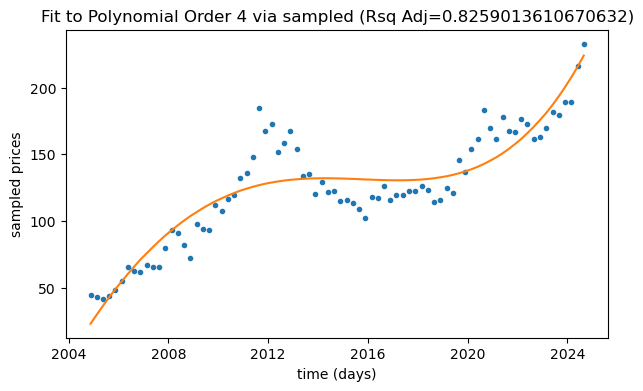

[ 2.30106301e+01  1.11321636e-01 -3.19671174e-05  3.19164979e-10
  6.51047053e-13]


In [17]:


### fit trend line
maxPolyOrder = 8
# need consecutive numbers, not dates, values not important, evenly spaced
x = np.arange(0,len(dates),1)
n = len(dates)
inds = np.arange(0,n,sampFreq)
x_samp = x[inds]
xScaleFact = 1
x4Fit = x/xScaleFact


rsqAdj, name, model, prices_sampHat = genStats.fit_simp_model(x_samp, prices_samp, maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_samp, prices_samp,'.',dates_samp,prices_sampHat,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+name+' via sampled (Rsq Adj='+str(rsqAdj)+')')
plt.show()

print(model.params)



Here a 4th order polynomial was found to produce the best 
adjusted r-squared value, 0.83.
The fit to a simple function was not as strong as with the other
stock related assets considered so far;
however, this could simply be due to the shorter time course provided.
A future, more rigirous comparision against primary assets is planned.


### ii. Define Deviations
We considered the price to be based on both a 'drift' and a 'noise' term.
In a perfect world, the drift would be defined by the trend and 
the noise by a uniformly distributed independnat random variable.
However (and as expected), there are clear deviations away from and 
back to the trend line over meaningfully long periods.
These are also easy to link to particular market events known to effect
the overall US economy.
In Project 202410, we chose to purse these further as abnormal deviations events.
We did the same here by considering the dispersion around the trend line
and the prices that are abnormally high or low.
Specifcally, we considered the possibility +/- 
the Median Absolute Deviation (MAD; corrected to match stdev under normality)
as a definition for abnormal price behaviour.
In Project 202410 we considered other options but dcided to move forward with MAD.



Dispersion (MAD): 0.11628357630667494


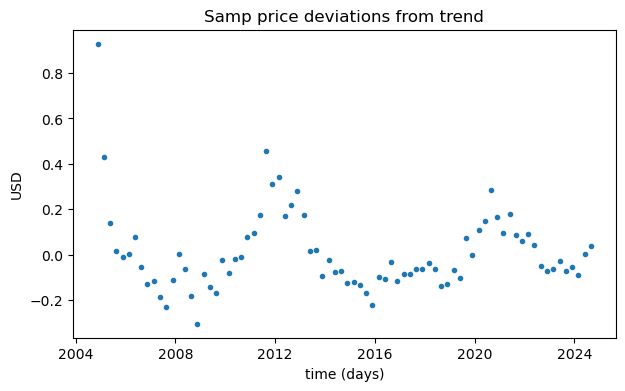

In [18]:

# consider deviations
method = 'MAD'

# get deviations
dev = genFin.dev(prices_samp,prices_sampHat)



sigma = genStats.disper(dev,method=method)
print('Dispersion (MAD): '+str(sigma))


# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(dates_samp, dev,'.')
plt.xlabel('time (days)')
plt.ylabel('USD')
plt.title('Samp price deviations from trend')
plt.show()




We found the typical expected price deviation to be +/- 0.11, 
lower than the S&P 500 (large cap) and 
Russell 2000 (small cap) stock indicies.

### iii. Identify Deviation Events
We defined a deviation event as a sequence of consecutive price
deviations that stay above the abnormal deviation threshold.
This period, in total, would be one deviation event of some period length.

Note: unlike the statistical tests where we used the sampled data, 
here we considered different resolutions starting with the full data set.
This is because we do not need the data set to be independently distributed.
In fact, we are in some sense suggesting that there is a dependance 
between the prices in a given event period.
This is somewhat related to the observations of long-term price memory 
in other projects and why we had to base sampiling on the return.

-------------------------------
--Deviations Root From Months--
-------------------------------


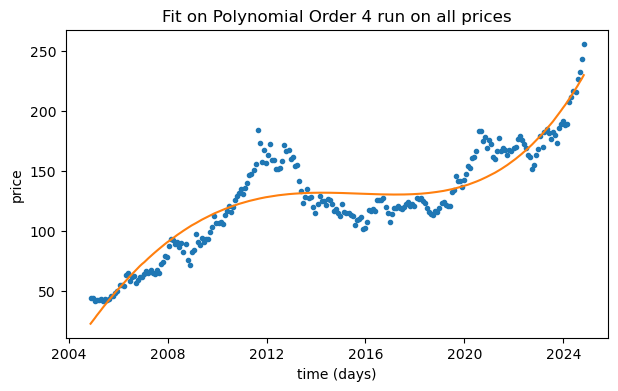

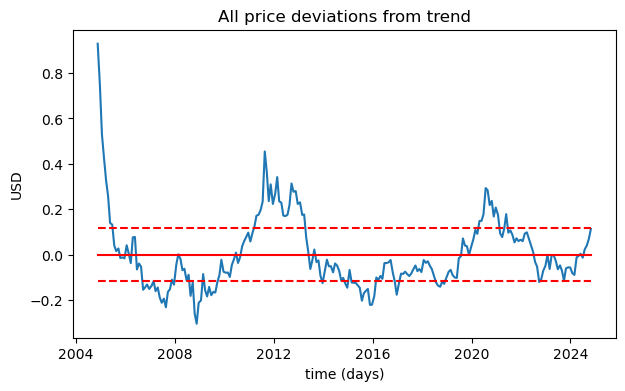

Threshold: 0.11628357630667494
Method: MAD
Number of Events: 15
Expected Event Length (M): 7.380952380952381
Abnormal Event Length (M): 13.805561994476657
Rare Event Length (M): 26.654781221525205
Crazy Event Length (M): 39.504000448573755
Event Lengths:
[ 29.  32.  32.  34.  64.  66. 153. 155. 186. 211. 242. 245. 304. 365.
 764.]
Total Time:
2882.0


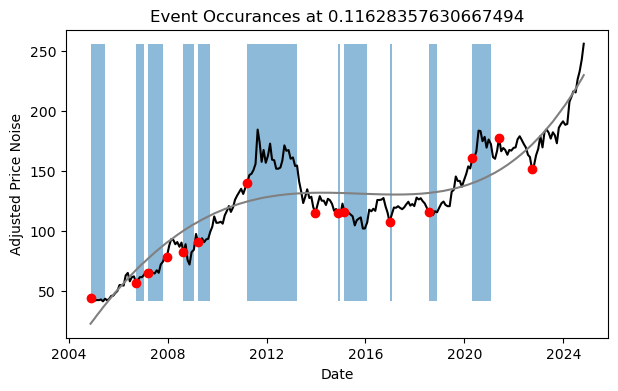

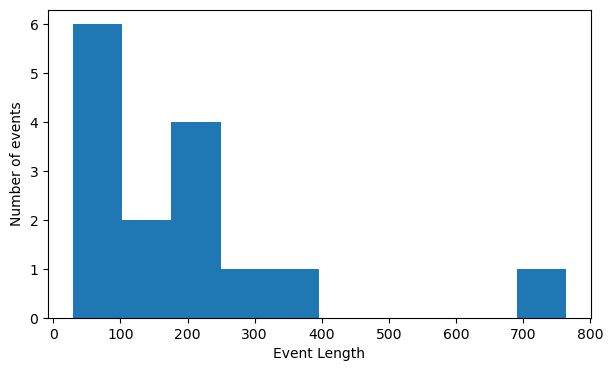

In [19]:
# first we need the trend for the whole data set


pricesHat = genStats.run_model(x4Fit,model,name)


print('-------------------------------')
print('--Deviations Root From Months--')
print('-------------------------------')


# get the disiered subset
n=len(dates)
inds=np.arange(0,n,month2days)
x=dates[inds]
y=prices[inds]
yHat=pricesHat[inds]

thresh = sigma

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(x, y,'.',x,yHat,'-')
plt.xlabel('time (days)')
plt.ylabel('price')
plt.title('Fit on '+name+' run on all prices')
plt.show()

devs = genFin.dev(y,yHat)
absDevs = np.abs(devs)

# Plot the data for sanity check
plt.figure(figsize=(7, 4))
plt.plot(x, devs)
plt.plot(x, devs*0,'-r')
plt.plot(x, devs*0+thresh,'--r')
plt.plot(x, devs*0-thresh,'--r')
plt.xlabel('time (days)')
plt.ylabel('USD')
plt.title('All price deviations from trend')
plt.show()
    

    
# flag deviations for this metric
eventInd, eventTime, eventLength = apa.flag_dev_event(x,y,yHat,thresh)

# need floats not timedelays for some processing
eventDays=utils.ns2days(eventLength)
    
print('Threshold: '+str(thresh))
print('Method: '+method)
print('Number of Events: '+str(len(eventTime)))
eventExp = np.median(eventDays)/month2days
print('Expected Event Length (M): '+str(eventExp))
eventDisper = genStats.disper(eventDays,method)/month2days
print('Abnormal Event Length (M): '+str(eventExp+eventDisper))
print('Rare Event Length (M): '+str(eventExp+3*eventDisper))
print('Crazy Event Length (M): '+str(eventExp+5*eventDisper))
print('Event Lengths:')
print(np.sort(eventDays))
print('Total Time:')
print(np.sum(eventDays))
inds = np.array(eventInd)
    
# Plot the data
plt.figure(figsize=(7, 4))
plt.plot(x, y,color='black')
plt.plot(x, yHat,color='gray')
plt.plot(x[eventInd],y[eventInd],'or')

plt.fill_between(x, min(y), max(y), where=(absDevs > thresh), alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Adjusted Price Noise')
plt.title('Event Occurances at ' + str(thresh))
plt.show()

    
plt.figure(figsize=(7, 4))
plt.hist(eventDays)
plt.xlabel('Event Length')
plt.ylabel('Number of events')
plt.title('')
plt.show()






GLD demonstrated different deviation events than stocks.
Two of the three longest events occured after the 2008 housing bubble
and following crash.
The first was a significant incrase in GLD price during the great recession.
Then, after more than 2 years, a downward trend during market recovey.
The third event of note was a rapid rise in price following the COVID market crash.
In general, these price deviation events lasted longer than those found 
in our previous analyses of stock indicies 
(projects 202410, 202411_apa_SP500 and 202411_apa_Russ2000).

We use this data to support the suggestions regarding small cap US stocks to long- and mid-term investors that: 
* abnormal price deviations, as the name suggests, are not common but are to be expected;
* these events are expected to last about 7-13 months for small cap US stocks;
* regular reallocation via standard optimization should be done every year (or less);
* early exiting or entering GLD should not be driven only by recent price trends less than 13 months;
* some investors with shorter time horizans may want to consider re-allocation based on other market factors for events lasting longer than 13 months;
* outside of other major factors, true long-term/ buy-and-hold investors should consider *not* making major changes based on events shorter than 2 years;  
* all investors are encuraged to consider re-allocation based on other market factors for events lasting longer than 3 years;
* however, don't excessivly run into or out of gold assets simply because they have been on a 2 year up or down streak as there are several historical examples of market corrections even at this time-scale (what goes up must come down, sort of).


## IV. Sampiling Period
The Mean-Variance analysis of Modern Portfolio Theory relies on 
statistical estimates of a expected return and risk 
(variance or other dispersion metric) parameters.
As shown above, we have considered median realitive return 
and its Median Absolute Deviation (MAD).
To calculate these, 
we need a proper sampiling frequency (determined in Section II)
and a sampiling period (number of consecutive time points to analyze over).

Previous analysies have shown that short sampiling periods lead to 
low-biased estimates of risk, as expected with small sample sizes.
However, long sampling periods (10, 20, 50 years) may not be avalible,
require additional compute resources and may not hold information relavant 
to the current market.

Here we applied the same method from project 202410.
We considered the period selection problem to be a 
standard paramater optimization problem.
Given that the goal of estimating a return over a given period 
is to use that as an estimate for future returns,
we chose to use the estimated expected return for a given period length
as the 'predictor' and to use some future return as the 'actual' observation.
For this future or actual return 
we chose a time delta equivlant to the suggested reallocation time (6mo).
An estimate of the expected return is calculated over a given period.
This is then compared to the return 6 months following the end of that period.

The objective function was simply normalized squared error,
where the normalization factor was the estimated dispersion 
(reffered to below as Risk Adjusted Error).
We focused on this Risk Adjusted Error
because it directly relates to the mean-variance method 
of optimizing expected return over risk.







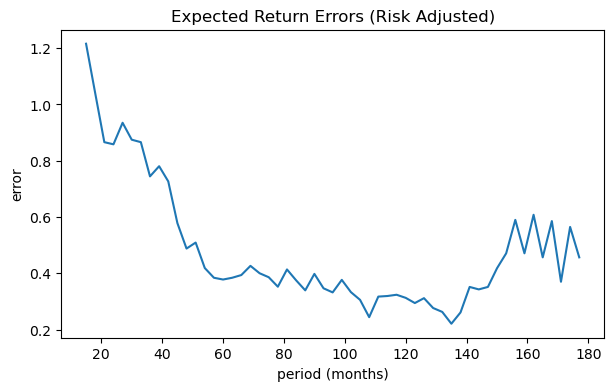

- Min Error: 0.22111353031900657
- Min Period: 135.0


In [22]:
# set method for estimatig return properties
method='Robust'
# reallocation time determined above
# used for delta between estimate and actual return
# 6 months in trading days
actDelta = 12*21
# adjust for samp freq (must be int)
actDelta = int(actDelta/sampFreq)

# set a max length based on total possible length (must be int)
pMax = int(0.75*len(returns_samp))
# requiering at least  data points for min
pMin = 5

# get the period range for later use
period = np.arange(pMin,pMax,1)
# for readability change to months
period = period*sampFreq/month2days


# get the errors
error = apa.calc_period_error(returns_samp,pMin,pMax,actDelta,scale='Disp',method=method)

# Plot the data 
plt.figure(figsize=(7, 4))
plt.plot(period, error)
plt.xlabel('period (months)')
plt.ylabel('error')
plt.title('Expected Return Errors (Risk Adjusted)')
plt.show()

# find and print minimum
minInd = np.argmin(error)
print('- Min Error: '+str(error[minInd]))
print('- Min Period: '+str(period[minInd]))





This shows that using:
(a) relative monthly (21 trading days) returns,
(b) a sampling interval of 63 trading days,
(c) a sample period of 135 months,
(d) a robust method for return parameter estimates and
(e) a reallcation target of 12 months,
we could typically expect a future return to 
be at a minumum (and well below) relative to the estimated dispersion.
We found this to be a sufficent result.

The risk adjusted error was 0.23, which was lower than what was found 
in our previous analyses of stock indicies 
(projects 202410, 202411_apa_SP500 and 202411_apa_Russ2000).
The optimal period length was also shorter; however, 
the shorter time course made avalible limits our  
ability to consider longer period lengths.

One interesting note that does have sufficent data for comparision, 
is the fact that it took twice as long for the error to drop compared to the stock indicies.
Here it took between 50 and 60 months for the curve to start to flatten out,
but in the stock indicies, and the S&P ETF (Project 202410), it took less than 30 months.
This is consistant with the longer time scales seen in the ACF and the deviation events.
Large price fluctuations seem to occur less frequently in GLD, 
and when they do occur they seem to hold longer.
Therefore, short periods of data (< 5 years) do a poor job making future estimates.
But these same features allow for relativly better estimates given longer periods.

Given the results here, 
we have made the following suggestions regarding sample period length for GLD and postulate
it may be sufficent for other gold, or even other precious metal, ETFs:
* 135 months for GLD;
* between 9 and 11 years for other presiouce metal ETFs, if possible;
* if not, then use the maximum avalible between 5 and 9 years and issue a yellow flag to the user; and
* issue a red flag if bellow 5 years.





## V. Historical Returns
A simple analysis was done regarding the average portfolio return 
depending on portfolio hold time.
We suggest that the longer a portfolio is held, the higher the return.
We looked at relative returns in one month increments from zero to 80% of the maximum available time.
This is due to statistical limitations at longer time frames.
In fact, we pushed the statistics a bit further (from 66% to 80% of max possible length)
to have some comparision to past sotck analyses.

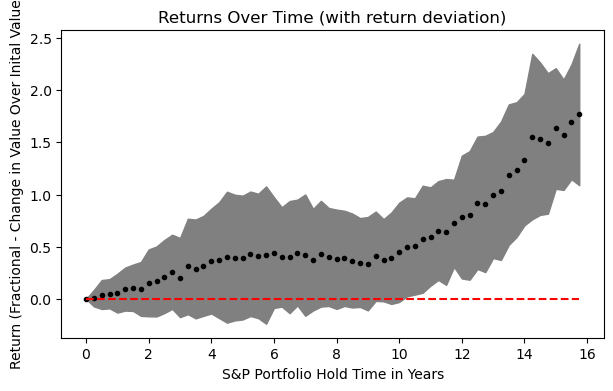

Return: 1.7668161434977578 at 15.75 for an annual of 0.1121788027617624
Return: 1.7668161434977578 at 15.75 for an annual of 0.1121788027617624 +/- 0.04301514882487112


In [24]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# calculate history of running returns 
returnHist, returnHistDisp, returnHistTime = apa.calc_running_returns(prices_samp,maxHoldFrac=0.80)

# convert hold time into years
returnHistTime = returnHistTime*sampFreq/month2days/12

plt.figure(figsize=(7, 4))
plt.plot(returnHistTime,returnHist,'.',color='black')
plt.plot(returnHistTime,returnHist*0,'--',color='red')
plt.fill_between(returnHistTime,returnHist+returnHistDisp,returnHist-returnHistDisp,color='gray')
plt.xlabel('S&P Portfolio Hold Time in Years')
plt.ylabel('Return (Fractional - Change in Value Over Inital Value')
plt.title('Returns Over Time (with return deviation)')
plt.show()

print('Return: '+str(returnHist[-1])+' at '+str(returnHistTime[-1])+
      ' for an annual of '+str(returnHist[-1]/returnHistTime[-1]))

# print the value if we held for the 16.5 years explored in previous project
targetYear = 16.5
ind = find_nearest(returnHistTime, targetYear)
print('Return: '+str(returnHist[ind])+' at '+str(returnHistTime[ind])+
      ' for an annual of '+str(returnHist[ind]/returnHistTime[ind])+
      ' +/- '+str(returnHistDisp[ind]/returnHistTime[ind]))





Over mid-term time-scales (< 10 years) the returns on GLD were 
typically low with a higher expected chance of loss compared to
analyses done on small and large cap US stock indices 
(projects 202411 apa Russ and SP500).
However, at a comparable long-term investment time frame 
(~16 years) we found GLD to be similar to the small cap index results,
at 11% +/- 4 points vs 12% +/- 4 points, respectivly.

It is well established that stocks and metals are inversly correlated.
This is just a different way to explore that same data.
Given the inverese correlation, comparible long-term returns and low variability, 
GLD (and likly other gold and precious metal assets)
is a reasonable addition to a blanced long-term portfolio.


## IV. Summary
Using this data we make the following suggestions for robust statistical 
parameters describing the gold ETF asset GLD (and possibly other precious metal ETFs):
* 21 trading day relative returns;
* sampling frequence, or more properly interval of 63 trading days; and
* sampling period of 135 months (~11 years) for GLD; and
* sampling period of 9 to 11 years for other precious metal ETFs if possible (otherwise 5-9 years with yellow flag, other wise red flag < 5 years of data).

For this assets contribution to a mid- to long-term investment portfolio 
(based on past data only), we expect:
* an expectation of 8-16% annual return on average if held for long-term investment (15+ years);
* a significantly lower expectation (about half) for buy-and-hold portfolio strategies within shorter time frames (< 10 years) and a higher possibility for loss;
* a reallocation based on robust optimization every 12 months or less;
* investors should expect major trend changes occasionally occuring and typically lasting 7 to 13 months;
* these events are tyepically inverse or shifted compared to US stock indicies;
* long-term invstors (expecting to hold for 10+ years) should avoid making changes based only on an unexpected change in an assets trend even if that change has presisted for two years; but
* all investors should start considering other market factors if an asset is deviating from its expected trend for more than a 3.25 years. 